In [42]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
!pip install ruptures
import ruptures as rpt
import shutil
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable


In [27]:
if not os.path.exists("content/processed_images"):
    os.makedirs("content/processed_images")

In [28]:
# Create a CLAHE object with desired parameters
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# Loop through all images in the rawdata folder
for file_name in os.listdir("rawdataset"):
    # Read the image
    img_path = os.path.join("rawdataset", file_name)
    img = cv2.imread(img_path)

    # Apply CLAHE to the image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_clahe = clahe.apply(gray)

   # Convert the processed image to RGB
    img_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)

    # Save the processed image in the processed_data folder
    out_path = os.path.join("content/processed_images", file_name)
    cv2.imwrite(out_path, img_rgb)

In [29]:
# Set the path to the directory containing the image files
img_dir = "content/processed_images"

# Get a list of image filenames sorted alphabetically
img_list = sorted(os.listdir(img_dir))

# Iterate through the list and rename each file
for i, old_name in enumerate(img_list):
    # Generate the new filename with leading zeros
    new_name = f"{i+1:04}.jpg"
    
    # Construct the full paths to the old and new files
    old_path = os.path.join(img_dir, old_name)
    new_path = os.path.join(img_dir, new_name)
    
    # Rename the file
    os.rename(old_path, new_path)

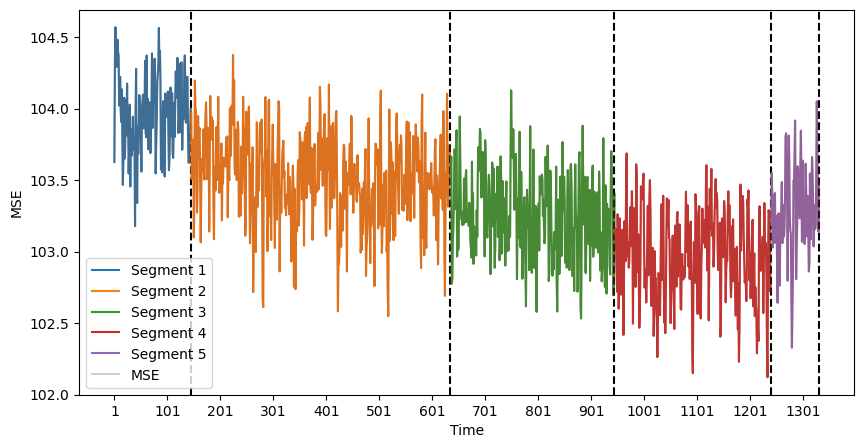

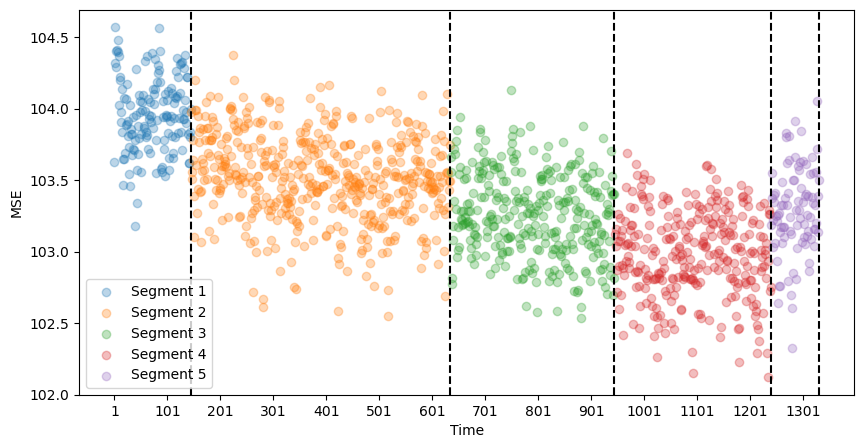

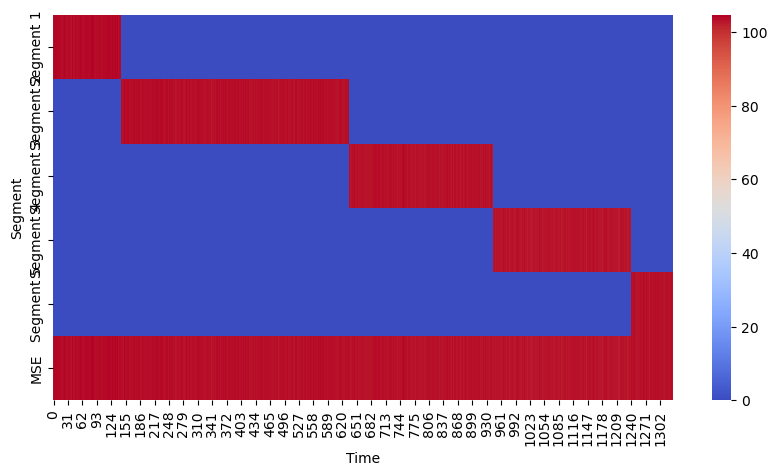

Changepoints: [145, 635, 945, 1240, 1331]


In [43]:
# Load the list of images in the processed_data folder
image_list = os.listdir("content/processed_images")
# Sort the list of images by timestamp
image_list.sort()

# Create an empty list to store the MSE values
mse_values = []

# Loop through pairs of consecutive images and calculate the MSE
for i in range(len(image_list) - 1):
    # Read the two consecutive images
    img_path_1 = os.path.join("content/processed_images", image_list[i])
    img_path_2 = os.path.join("content/processed_images", image_list[i+1])
    img1 = cv2.imread(img_path_1)
    img2 = cv2.imread(img_path_2)
    # Compute the MSE between the two images
    mse = np.mean((img1 - img2)**2)

    # Add the MSE value to the list
    mse_values.append(mse)

# Create a time axis based on the timestamps in the image filenames
time_axis = [int(img.split(".")[0]) for img in image_list[:-1]]

# Run changepoint detection on the MSE values using the Pelt algorithm
model = "rbf"
algo = rpt.Pelt(model=model).fit(np.array(mse_values))
result = algo.predict(pen=10)
# Plot the segmented time series with changepoints
fig, ax = plt.subplots(figsize=(10, 5))
changepoints = []
for i, rpt_id in enumerate(result):
    if i == 0:
        start = 0
    else:
        start = result[i-1]
    end = result[i]
    ax.plot(time_axis[start:end], mse_values[start:end], label=f"Segment {i+1}")
    ax.axvline(x=time_axis[end-1], color='k', linestyle='--')  # add vertical line at changepoint
    changepoints.append(time_axis[end-1])  # add changepoint to the list
ax.plot(time_axis, mse_values, alpha=0.3, label="MSE")
ax.legend()
plt.xlabel("Time")
plt.ylabel("MSE")
plt.xticks(np.arange(time_axis[0], time_axis[-1], step=100))
plt.show()


#scatter plot
fig, ax = plt.subplots(figsize=(10, 5))
changepoints = []
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
for i, rpt_id in enumerate(result):
    if i == 0:
        start = 0
    else:
        start = result[i-1]
    end = result[i]
    ax.scatter(time_axis[start:end], mse_values[start:end], label=f"Segment {i+1}", alpha=0.3, color=colors[i])
    ax.axvline(x=time_axis[end-1], color='k', linestyle='--')  # add vertical line at changepoint
    changepoints.append(time_axis[end-1])  # add changepoint to the list
ax.legend()
plt.xlabel("Time")
plt.ylabel("MSE")
plt.xticks(np.arange(time_axis[0], time_axis[-1], step=100))
plt.show()

# Generate a 2D matrix with the MSE values and changepoints
matrix = np.zeros((len(changepoints) + 1, len(time_axis)))
for i in range(len(changepoints)):
    if i == 0:
        start = 0
    else:
        start = result[i-1]
    end = result[i]
    matrix[i, start:end] = mse_values[start:end]
matrix[-1, :] = mse_values

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(matrix, cmap="coolwarm", ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Segment")
ax.set_yticklabels([f"Segment {i}" for i in range(1, len(changepoints) + 1)] + ["MSE"])
plt.show()


# Print the list of changepoints
print("Changepoints:", changepoints)

In [33]:
import shutil

# Create directories for the 5 classes
class1_dir = "content/Train/Phase1"
class2_dir = "content/Train/Phase2"
class3_dir = "content/Train/Phase3"
class4_dir = "content/Train/Phase4"
class5_dir = "content/Train/Phase5"

os.makedirs(class1_dir, exist_ok=True)
os.makedirs(class2_dir, exist_ok=True)
os.makedirs(class3_dir, exist_ok=True)
os.makedirs(class4_dir, exist_ok=True)
os.makedirs(class5_dir, exist_ok=True)

# Copy images to the appropriate class directories based on the changepoints
for i, rpt_id in enumerate(result):
    if i == 0:
        start = 0
    else:
        start = result[i-1]
    end = result[i]
    
    if i == 0:
        class_dir = class1_dir
    elif i == 1:
        class_dir = class2_dir
    elif i == 2:
        class_dir = class3_dir
    elif i == 3:
        class_dir = class4_dir
    else:
        class_dir = class5_dir
    
    for j in range(start, end):
        old_path = os.path.join("content/processed_images", f"{time_axis[j]:04}.jpg")
        new_path = os.path.join(class_dir, f"{time_axis[j]:04}.jpg")
        shutil.copy(old_path, new_path)

In [34]:
import os
import shutil
import random

# Define directories for train, validation, and test folders
train_dir = "content/Train"
val_dir = "content/Validation"
test_dir = "content/Test"
classes = ["Phase1", "Phase2", "Phase3", "Phase4", "Phase5"]

# Create directories for the 5 classes in train, validation, and test folders
for dir_path in [train_dir, val_dir, test_dir]:
    for class_name in classes:
        os.makedirs(os.path.join(dir_path, class_name), exist_ok=True)

# Move 20% of images from each class directory in train folder to validation and test folders
for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    image_list = os.listdir(class_dir)
    num_images = len(image_list)
    num_val_images = int(num_images * 0.2)
    val_image_list = random.sample(image_list, num_val_images)
    test_image_list = random.sample(list(set(image_list) - set(val_image_list)), num_val_images)
    for img in val_image_list:
        old_path = os.path.join(class_dir, img)
        new_path = os.path.join(val_class_dir, img)
        shutil.move(old_path, new_path)
    for img in test_image_list:
        old_path = os.path.join(class_dir, img)
        new_path = os.path.join(test_class_dir, img)
        shutil.move(old_path, new_path)

